In [827]:
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import os
import numpy as np
import re
import random
import asyncio
import aiohttp
import cv2

# Resolutions list

In [69]:
res_16_9 = [(1280,720),(1920,1080),(800,450),(640,360)]
res_191_100 = [(1200,628),(600,314)]
res_2_3 = [(400,600),(300,450),(1000,1500)]
res_1080p = [(1920,1080)]
res_540p = [(960, 540)]
res_720p = [(1280,720)]

# Text samples

In [70]:
loremIpsum = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'
shakespear = "Shall I compare thee to a summer's day?Thou art more lovely and more temperate:Rough winds do shake the darling buds of May,And summer's lease hath all too short a date:Sometime too hot the eye of heaven shines,And often is his gold complexion dimmed,And every fair from fair sometime declines,By chance, or nature's changing course untrimmed:But thy eternal summer shall not fade,Nor lose possession of that fair thou ow'st,Nor shall death brag thou wander'st in his shade,When in eternal lines to time thou grow'st,So long as men can breathe, or eyes can see,So long lives this, and this gives life to thee."
pulpFictionJules = """And I will strike down upon thee with great vengeance 
and furious anger those who attempt to poison and destroy my brothers. 
And you will know I am the Lord when I lay my vengeance upon you."""
gbuBlondie = "You see in this world there's two kinds of people, my friend - those with loaded guns, and those who dig. You dig."
godfather= "I'm gonna make him an offer he can't refuse."

# Util functions

In [71]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [72]:
def formatRgbTupleToHex(rgbTupleColor):
    return '#{:02x}{:02x}{:02x}'.format( rgbTupleColor[0],rgbTupleColor[1],rgbTupleColor[2])

In [73]:
def randomColor():
    return tuple(np.random.choice(range(256), size=3))

In [74]:
def randomHexColor():
    c = "#"+"%03x" % random.randint(0, 0xFFFFFF)
    while (len(c) != 7):
        c = "#"+"%03x" % random.randint(0, 0xFFFFFF)
    return c

In [75]:
def createFolder(dirName):
    if not os.path.exists(dirName):
        os.makedirs(dirName)

In [76]:
def removeAllImages():
    for file in os.listdir('images'):
        os.remove('images/' + file)

In [77]:
def saveToFile(img, splitIntoFolders, fontSize, fontType, res, indexer, fileNamePrefix = '',):
    if (splitIntoFolders):
        path = os.path.join('images/', fontType, str(fontSize))
        createFolder(path)   
        img.save(os.path.join(path, fileNamePrefix + '-'.join([str(fontSize)+"pt",'x'.join(map(str, res)), str(indexer)])) + '.png')
    else:
        dirPath = os.path.join('images')
        createFolder(dirPath)   
        filePath = os.path.join(dirPath, fileNamePrefix + '-'.join([str(fontSize)+"pt", 'x'.join(map(str, res)), str(indexer)]) + '.png')
        img.save(filePath)

In [78]:
def get_hex_code(color):
    result = re.match(r'^#?([a-f0-9]{3,3}|[a-f0-9]{6,6})$', color)
    
    if result is None:
        raise Exception('Could not extract color')
        
    result = list(result.group(1))

    if len(result) == 6:
        result = [result[i] + result[i+1] for i in range(0, len(result), 2)]
    else:
        result = [result[i] + result[i] for i in range(0, len(result))]
        
    return [int(hex_code, 16) for hex_code in result]

In [79]:
def calculate_luminace(color_code):
    index = float(color_code) / 255 

    if index < 0.03928:
        return index / 12.92
    else:
        return ( ( index + 0.055 ) / 1.055 ) ** 2.4
    

In [80]:
def calculate_relative_luminance(rgb):
    return 0.2126 * calculate_luminace(rgb[0]) + 0.7152 * calculate_luminace(rgb[1]) + 0.0722 * calculate_luminace(rgb[2]) 


In [81]:
def hexColorContrast(color1, color2):
    #print("Color1: %s Color2: %s" % (color1, color2))
    color_one = get_hex_code(color1)
    color_two = get_hex_code(color2)

    col_lum_1 = calculate_relative_luminance(color_one)
    col_lum_2 = calculate_relative_luminance(color_two)
    
    if (col_lum_1 > col_lum_2):
        light = col_lum_1
        dark = col_lum_2
    else:
        light = col_lum_2
        dark = col_lum_1

    contrast_ratio = (light + 0.05) / (dark + 0.05);
    
    #print("Contrast: %s, Light luminance: %s, Dark luminance: %s" % (contrast_ratio, light + 0.05, dark + 0.05))
    if contrast_ratio < 3:
        usable_for = "Below 3"
    elif contrast_ratio >= 3 and contrast_ratio < 4.5:
        usable_for = "Between 3 and 4.5"
    elif contrast_ratio >= 4.5 and contrast_ratio < 7:
        usable_for = "AA level"
    elif contrast_ratio >= 7:
        usable_for = "AAA level"

    #print(usable_for)
    return contrast_ratio
    #return '{0:.2f}'.format(contrast_ratio)

In [82]:
def prepareNamePrefix(func, colors):
    bgContrast = colors[3]
    txtBgContrast1 = colors[4]
    txtBgContrast2 = colors[5]

    colorHex = colors[6]
    secondColorHex = colors[7]
    txtColorHex = colors[8]
    
    if (not(func == twoColoredRectangleBackground or func == twoColoredHorizontalRectangleBackground)):   
        secondColorHex = colorHex
        txtBgContrast2 = txtBgContrast1
    
    return "bgContrast_%s_txtToBg1_%s_txtToBg2_%s_c1_%s_c2_%s_tc_%s_" % (bgContrast, 
                                                                           txtBgContrast1, 
                                                                           txtBgContrast2, 
                                                                           colorHex.lstrip('#'), 
                                                                           secondColorHex.lstrip('#'), 
                                                                           txtColorHex.lstrip('#'))

In [ ]:
def get_colors_with_contrast(bg_color, )

In [83]:
def getColorsOfGivenContrast(bgColorsMaxContrast, bgToTxtMinContrast):
    color = randomColor()
    secondColor = randomColor()
    textColor = randomColor()

    colorHex = formatRgbTupleToHex(color)
    secondColorHex = formatRgbTupleToHex(secondColor)
    textColorHex = formatRgbTupleToHex(textColor)

    backgroundContrast = hexColorContrast(colorHex, secondColorHex)
    textToBackgroundContrast1 = hexColorContrast(textColorHex, colorHex)
    textToBackgroundContrast2 = hexColorContrast(textColorHex, secondColorHex)

    while(not(backgroundContrast < bgColorsMaxContrast and textToBackgroundContrast1 > bgToTxtMinContrast and textToBackgroundContrast2 > bgToTxtMinContrast)):
        color = randomColor()
        secondColor = randomColor()
        textColor = randomColor()

        colorHex = formatRgbTupleToHex(color)
        secondColorHex = formatRgbTupleToHex(secondColor)
        textColorHex = formatRgbTupleToHex(textColor)

        backgroundContrast = hexColorContrast(colorHex, secondColorHex)
        textToBackgroundContrast1 = hexColorContrast(textColorHex, colorHex)
        textToBackgroundContrast2 = hexColorContrast(textColorHex, secondColorHex)
    return (color, secondColor, textColor, backgroundContrast, textToBackgroundContrast1, textToBackgroundContrast2, colorHex, secondColorHex, textColorHex)

In [84]:
async def get_random_photo_background(shape):
    url = f'https://picsum.photos/{shape[1]}/{shape[0]}'
    async with aiohttp.ClientSession() as session, session.get(url=url) as response:
        resp = await response.read()
        image_array = np.asarray(bytearray(resp), dtype='uint8')
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        return image

# Base of the image, background functions

In [85]:
def simpleBackground(size, color, mode='RGB'):
    return Image.new(mode, size, color)

In [86]:
#it will generate background, half colored with given color parameter, half with random one
def twoColoredRectangleBackground(size, color, secondColor=randomColor(), mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.rectangle((int(size[0]/2),size[1],size[0],0), fill=secondColor)
    return img.copy()

In [87]:
def twoColoredHorizontalRectangleBackground(size, color, secondColor=randomColor(), mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.rectangle((0, int(size[1]/2), size[0], size[1]), fill=secondColor)
    return img.copy()

In [88]:
def multiColoredRectangleBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    for i in range(1,6):
        draw.rectangle((int(size[0]/5)*i,size[1],size[0],0), fill=randomColor())
    return img.copy()

In [89]:
#it will generate background, half colored with given color parameter diagonally, half with random one
def twoColoredPolygonBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.polygon([(0,0),(size[0],size[1]),(size[0],0)], fill=randomColor())
    return img.copy()

In [90]:
#it will generate background, half colored with given color parameter diagonally, half with random one
def twoColoredInvertedPolygonBackground(size, color, mode='RGB'):
    img = Image.new(mode, size, color)
    draw = ImageDraw.Draw(img)
    draw.polygon([(size[0],0),(size[0],size[1]),(0,size[1])], fill=randomColor())
    return img.copy()

In [91]:
async def photoBackground(size):
    img = await get_random_photo_background(size)
    return Image.fromarray(img)

# Random triangles and circles

In [92]:
def addRandomCircles(img):
    circleMaxSize = np.random.choice(range(5,450))
    circleNumber = np.random.choice(range(30, 300))
    draw = ImageDraw.Draw(img)
    for i in range(1, circleNumber):
        x1 = np.random.choice(range(img.size[0]))
        y1 = np.random.choice(range(img.size[1]))
        circSize = np.random.choice(range(int(circleMaxSize)))
        draw.ellipse((x1, y1, x1+circSize, y1+circSize), fill = randomColor())
    return img.copy()

In [93]:
def addRandomTriangles(img):
    triangleMaxSize = np.random.choice(range(15,450))
    triangleNumber = np.random.choice(range(30, 300))
    draw = ImageDraw.Draw(img)
    for i in range(1, triangleNumber):
        try:
            triangleSize = np.random.choice(range(triangleMaxSize))
            while(triangleSize == 1 or triangleSize == 0):
                triangleSize = np.random.choice(range(triangleMaxSize))
            
            x0 = np.random.choice(range(img.size[0]))
            y0 = np.random.choice(range(img.size[1]))
        
            x1 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            x2 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            x3 = x0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
        
            y1 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            y2 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
            y3 = y0 + np.random.choice(range(int(-0.5*triangleSize), int(0.5*triangleSize)))
        except:
            pass
        
        draw.polygon([(x1,y1),(x2,y2),(x3,y3)], fill = randomColor())
    return img.copy()

# Image modification

In [94]:
def blurImage(img, gausRad = 2):
    img = img.filter(ImageFilter.GaussianBlur(gausRad))
    return img.copy()

# Random Shakespear text

In [95]:
def addText(img, randomize = False, sourceText = shakespear,color=(0,0,0), fontSize=15, fontType='arial.ttf'):
    draw = ImageDraw.Draw(img)
    #fontSize in point (pt)
    font = ImageFont.truetype(fontType, fontSize)

    if(randomize):
        x = np.random.choice(range(img.size[0]-50))
        y = np.random.choice(range(img.size[1]-50))
        spacesList = [pos for pos, char in enumerate(sourceText) if char == ' ']
        r2 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r2)]
        r1 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r1)]
        r3 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r3)]
        r4 = np.random.choice(spacesList)

        r = [r1,r2,r3,r4]
        sorted(r)
        text = sourceText[r[0]:r[1]] +"\n"+ sourceText[r[1]:r[2]] + "\n" + sourceText[r[2]:r[3]]
    else:
        x = 40
        y = int(img.size[1]/2) - int(font.size/1.5)
        text = sourceText
    
    draw.text((x,y), text, fill=color, font=font)
    return img.copy()

# Available fonts

In [96]:
arialGeo = 'fonts/Arial_GEO.TTF'
arialNarrow = 'fonts/Arialn.ttf'
arialNarrowBold = 'fonts/Arialnb.ttf'
arialBlackMegaBold = 'fonts/ariblk.ttf'
arialGeoItallic = 'fonts/G_ari_i.TTF'

timesNewRoman = 'fonts/times_new_roman.ttf'
timesNewRomanItalic = 'fonts/times_new_roman_italic.ttf'
timesNewRomanBold = 'fonts/times_new_roman_bold.ttf'

verdana = 'fonts/verdana.ttf'
verdanaItalic = 'fonts/verdana_italic.ttf'
verdanaBold = 'fonts/verdana_bold.ttf'

# Main function

<ipython-input-923-2ea1cafe4691>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


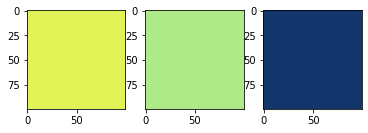

In [927]:
c = getColorsOfGivenContrast(5,7)
visualizeColors(c[0], c[1], c[2])

In [923]:
def visualizeColors(c1, c2, c3):
    fig,ax = plt.subplots(1,3)
    im1 = Image.new('RGB', (100,100), c1)
    im2 = Image.new('RGB', (100,100), c2)
    im3 = Image.new('RGB', (100,100), c3)
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(im3)

    fig.show()

In [961]:
#backgroundFunc - function that will generate background image
#resList - list of resolution of images that will be generated
#repetition - how many images are generated for given resolution
#name addition - prefix added for each generated file

async def generateImagesText(backgroundFunc, fontTypeList, resList, fontSizeList, repetition, fileNamePrefix, splitIntoFolders = True):
    indexer = 1
    for func in backgroundFunc:
        for fontType in fontTypeList:
            for res in resList:
                for fntSize in fontSizeList:
                    for i in range(1, repetition+1):
                        #fontSize = np.random.choice(range(10, 50))
                        fontSize = fntSize
                        #blurLevel = np.random.choice(range(0,5))

                        colors = getColorsOfGivenContrast(bgColorsMaxContrast = 5, bgToTxtMinContrast = 7)
                        color = colors[0]
                        secondColor = colors[1]
                        txtColor = colors[2]
                        
                        if func == twoColoredRectangleBackground or func == twoColoredHorizontalRectangleBackground:
                            img = func(res, color, secondColor)
                        elif func == photoBackground:
                            img = await func(res)
                        else:
                            img = func(res, color)
                                 
                        namePrefix = prepareNamePrefix(func, colors)
                                           
                        #img = addRandomCircles(img)
                        #img = addRandomTriangles(img)
                        #img = blurImage(img, gausRad = blurLevel)
                        
                        #sourceText = godfather
                        sourceText = get_random_slogan()
                        
                        #img = addText(img, randomize=False, sourceText=sourceText, color=txtColor, fontSize=fontSize, fontType=fontType)
                        img = addRotatedText(img, randomize=False, sourceText=sourceText, color=txtColor, fontSize=fontSize, fontType=fontType)
                        
                        
                        
                        
                        saveToFile(img=img, splitIntoFolders=splitIntoFolders, 
                                   fileNamePrefix=namePrefix, 
                                   fontSize=fontSize,
                                   fontType=fontType,
                                   res=res, indexer=indexer)
                        indexer +=1

# Pick your parameters
### Comment out background functions, fonts, that you don't want to have generated
### Pick resolutions, you can pick existing list (see list on the top) or enter it in format [(height,width)]

In [928]:
backgroundFunctions = [    
    #simpleBackground,     
    twoColoredRectangleBackground,   
    twoColoredHorizontalRectangleBackground,   
    twoColoredPolygonBackground, 
    twoColoredInvertedPolygonBackground, 
   # multiColoredNotEqualRectangleBackground, 
   # multiColoredRectangleBackground
   # photoBackground
]

In [844]:
fontsList = [timesNewRoman,
             #timesNewRomanItalic, 
             #timesNewRomanBold, 
             #verdana, 
             verdanaItalic, 
             #verdanaBold, 
             arialGeoItallic, 
             #arialNarrow, 
             #arialNarrowBold, 
             arialBlackMegaBold]

In [952]:
resList = res_540p

In [951]:
fontSizeList = (45, 60)

In [847]:
repetition = 1

In [848]:
#Just for information purposes
n = len(backgroundFunctions) * len(fontsList) * len(resList) * len(fontSizeList) * repetition
print("Number of images that will be generated: " + str(n))

Number of images that will be generated: 24


In [965]:
img = Image.open('images/bgContrast_1.028224047291344_txtToBg1_12.342844143240232_txtToBg2_12.342844143240232_c1_410402_c2_410402_tc_37fe07_45pt-960x540-21.png')

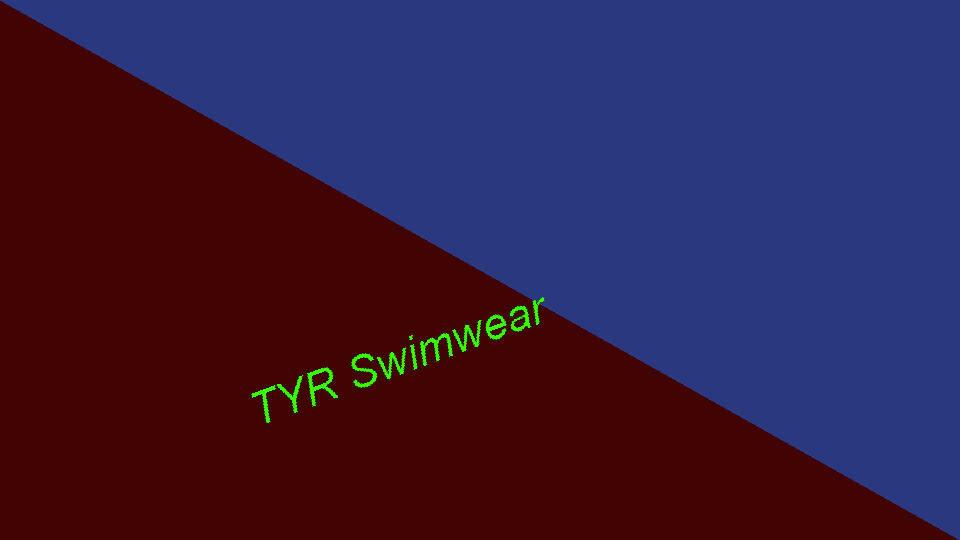

In [966]:
img

In [975]:
def add_image_perspective(img):
    width, height = img.size
    m = 0.5
    xshift = abs(m) * width
    new_width = width + int(round(xshift))
    return img.transform((new_width, height), Image.AFFINE, (1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.BICUBIC)

(960, 540)

In [1023]:
def find_coefs(original_coords, warped_coords):
        matrix = []
        for p1, p2 in zip(original_coords, warped_coords):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

        A = np.matrix(matrix, dtype=np.float)
        B = np.array(warped_coords).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

<ipython-input-1023-6fff8f889e89>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = np.matrix(matrix, dtype=np.float)


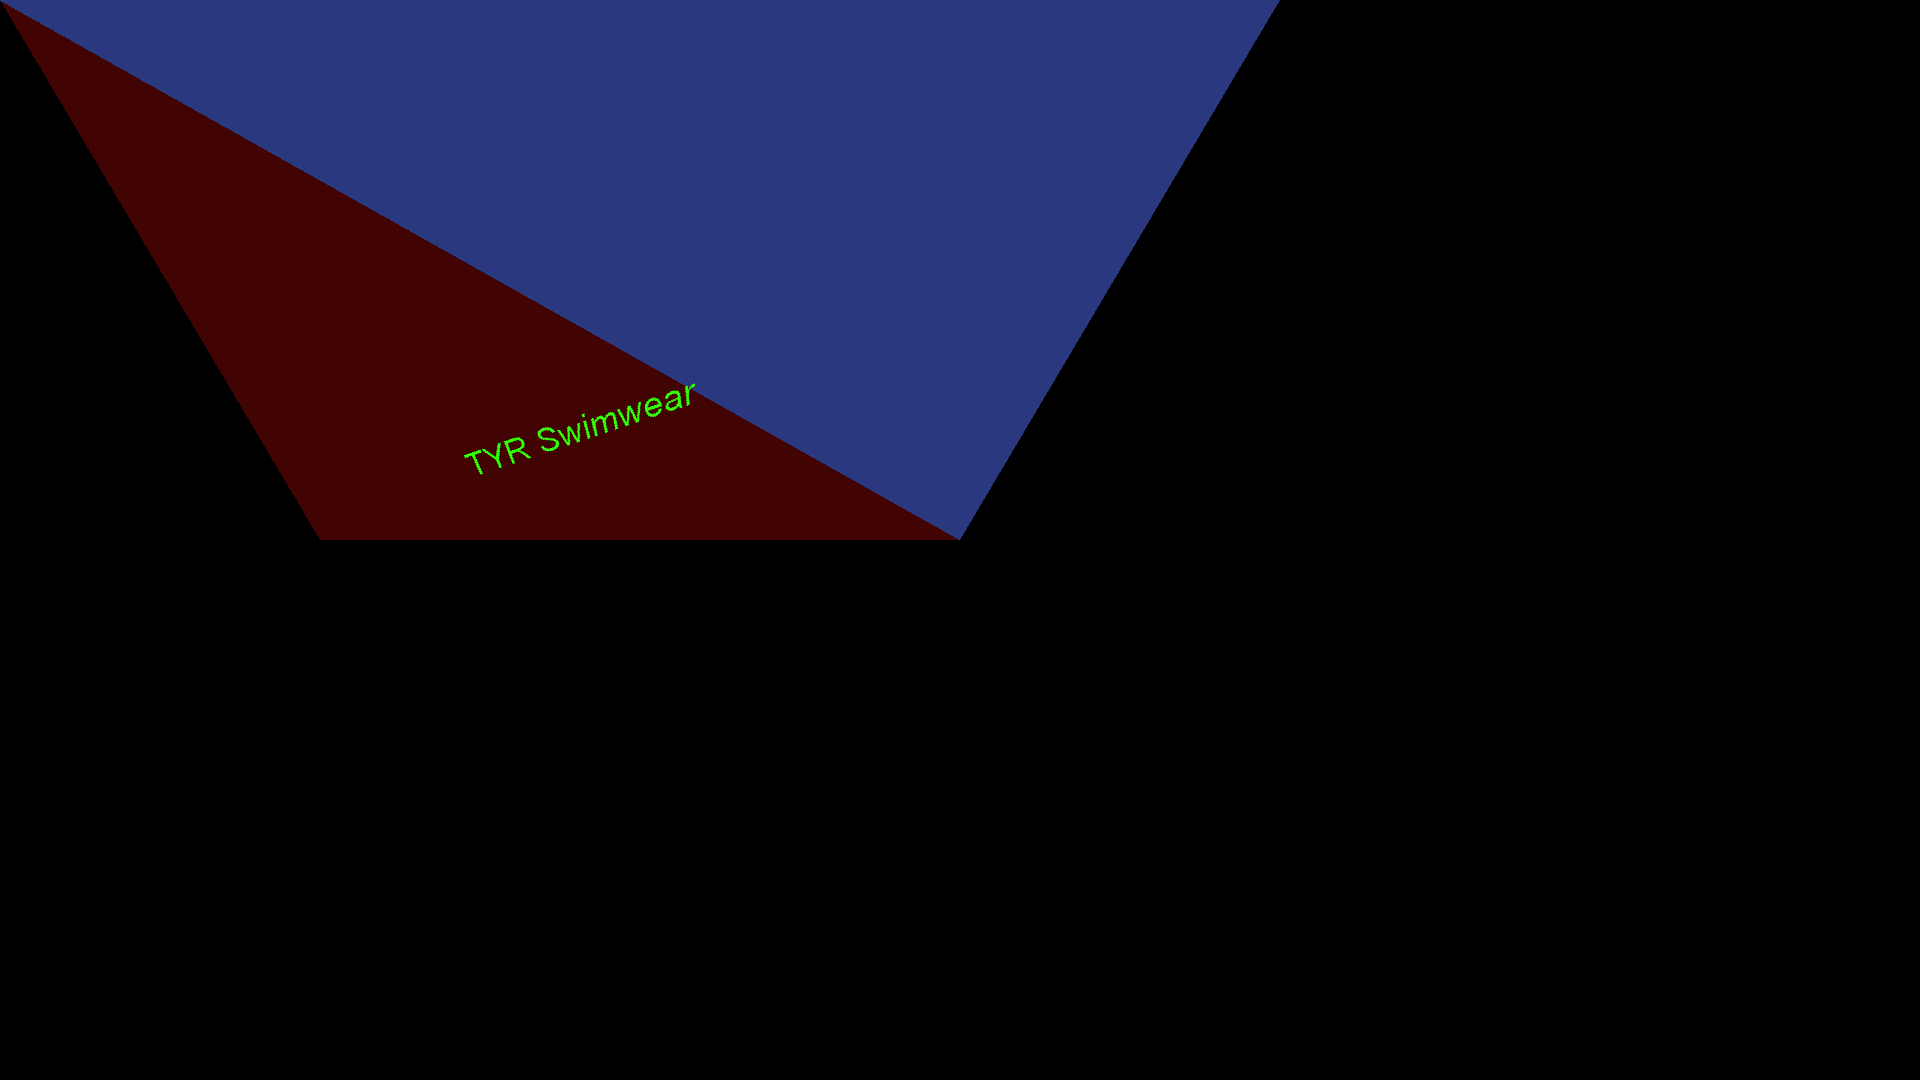

In [1172]:
x, y = img.size
coefs = find_coefs(
    [(0, 0), (x, 0), (x, y), (0, y)],
    [(0, 0), (x*0.75, 0), (x, y), (-x*0.5, y)])

width, height = img.size
m = 0.5
xshift = abs(m) * width
new_width = width*2
new_height = height*2
img.transform((new_width, new_height), Image.PERSPECTIVE,
coefs, Image.BICUBIC)

In [948]:
def addRotatedText(img, randomize = False, sourceText = shakespear, color=(0,0,0), fontSize=15, fontType='arial.ttf'):
    draw = ImageDraw.Draw(img)
    #fontSize in point (pt)
    font = ImageFont.truetype(fontType, fontSize)

    if(randomize):
        x = np.random.choice(range(int(img.size[0]/2)-50))
        y = np.random.choice(range(int(img.size[1]*0.75)-50))
        spacesList = [pos for pos, char in enumerate(sourceText) if char == ' ']
        r2 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r2)]
        r1 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r1)]
        r3 = np.random.choice(spacesList)
        del spacesList[spacesList.index(r3)]
        r4 = np.random.choice(spacesList)

        r = [r1,r2,r3,r4]
        sorted(r)
        text = sourceText[r[0]:r[1]] +"\n"+ sourceText[r[1]:r[2]] + "\n" + sourceText[r[2]:r[3]]
    else:
        x = 40
        y = int(img.size[1]/2) - int(font.size/1.5)
        text = sourceText
    
    f = ImageFont.truetype(fontType, fontSize)
    txt=Image.new('L', img.size)
    d = ImageDraw.Draw(txt)
    d.text( (0, 0), str(sourceText),  font=f, fill=255)
    w=txt.rotate(20,  expand=1)

    img.paste( ImageOps.colorize(w, (0,0,0), color), (242,60),  w)
    
    return img.copy()

In [962]:
removeAllImages()

In [963]:
await generateImagesText(backgroundFunctions, fontsList, resList, fontSizeList, repetition, fileNamePrefix='', splitIntoFolders=False)